In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import h5py
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [63]:
herwig = "../data/events_anomalydetection_DelphesHerwig_qcd_features.h5"
pythiabg = "../data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5"
pythiasig = "../data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"

datatypes = ["herwig", "pythiabg", "pythiasig"]
df = {}

df["herwig"] = pd.read_hdf(herwig)
df["pythiabg"] = pd.read_hdf(pythiabg)
df["pythiasig"] = pd.read_hdf(pythiasig)

In [64]:
for datatype in datatypes:
    df[datatype]["tau21j1"] = df[datatype]["tau2j1"] / df[datatype]["tau1j1"]
nsubjetherwig = df["herwig"]["tau21j1"]
data = np.asarray(nsubjetherwig)
data2 = data[0:5000]
short_data = data[0:5000]
short_data = torch.FloatTensor(short_data)
short_data = short_data.unsqueeze(0)
print(short_data.size())

torch.Size([1, 5000])


In [65]:
short_data = short_data.permute(1,0)
print(short_data.size())

torch.Size([5000, 1])


In [66]:
Series_Length = 1
g_input_size = 1    
g_hidden_size = 32
g_output_size = Series_Length
d_input_size = Series_Length
d_hidden_size = 32
d_output_size = 1
d_minibatch_size = 5000
g_minibatch_size = 5000

num_epochs = 100000
print_interval = 1000
d_learning_rate = 4e-3
g_learning_rate = 8e-3

In [67]:
def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()
noise_data  = get_noise_sampler()

In [68]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        # Fully-connected layer
        fc = torch.nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        torch.nn.init.normal(fc.weight)
        torch.nn.init.constant(fc.bias, 0.0)

        # Hidden layer
        self.hidden_layer = torch.nn.Sequential(
            fc,
            torch.nn.ReLU()
        )

        # Output layer
        self.output_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        torch.nn.init.normal(self.output_layer.weight)
        torch.nn.init.constant(self.output_layer.bias, 0.0)

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


# Discriminator
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        # Fully-connected layer
        fc1 = torch.nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        torch.nn.init.normal(fc1.weight)
        torch.nn.init.constant(fc1.bias, 0.0)

        # Hidden layer
        self.hidden_layer = torch.nn.Sequential(
            fc1,
            torch.nn.ReLU()
        )

        # Fully-connected layer
        fc2 = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        torch.nn.init.normal(fc2.weight)
        torch.nn.init.constant(fc2.bias, 0.0)

        # Output layer
        self.output_layer = torch.nn.Sequential(
            fc2,
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

In [69]:
G = Generator(input_dim=g_input_size, hidden_dim=g_hidden_size, output_dim=g_output_size)
D = Discriminator(input_dim=d_input_size, hidden_dim=d_hidden_size, output_dim=d_output_size)

In [76]:
criterion = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate ) #, betas=optim_betas)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate ) #, betas=optim_betas)

In [77]:

def train_D_on_actual() :
    real_data = short_data
    decision = D(real_data)
    error = criterion( decision, torch.ones(d_minibatch_size, 1 ))  # ones = true
    error.backward()
    return error.item()

def train_D_on_generated() :
    noise = noise_data( d_minibatch_size, g_input_size )
    fake_data = G( noise ) 
    decision = D( fake_data )
    error = criterion( decision, torch.zeros( d_minibatch_size, 1 ))  # zeros = fake
    error.backward()
    return error.item()
    
def train_G():
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    fake_decision = D( fake_data )
    error = criterion( fake_decision, torch.ones( g_minibatch_size, 1 ) ) 

    error.backward()
    return error.item(), fake_data

In [72]:
g_loss = []
d_loss = []
for epoch in range(num_epochs):
    D.zero_grad()
    
    D_real_loss = train_D_on_actual()    
    D_fake_loss = train_D_on_generated()
    d_optimizer.step()
    D.zero_grad()
    G.zero_grad()
    G_loss,g_generated = train_G()
    g_optimizer.step()
    
    g_loss.append(G_loss)
    d_loss.append(D_real_loss+D_fake_loss)
    if( epoch % print_interval) == (print_interval-1) :
        print( "Epoch %6d. Loss %5.3f" % ( epoch+1, G_loss ) )
        
print( "Training complete" )

Epoch   1000. Loss 0.685
Epoch   2000. Loss 0.586
Epoch   3000. Loss 0.695
Epoch   4000. Loss 0.820
Epoch   5000. Loss 0.680
Epoch   6000. Loss 0.672
Epoch   7000. Loss 0.684
Epoch   8000. Loss 0.754
Epoch   9000. Loss 0.699
Epoch  10000. Loss 0.694
Epoch  11000. Loss 0.777
Epoch  12000. Loss 0.696
Epoch  13000. Loss 0.683
Epoch  14000. Loss 0.671
Epoch  15000. Loss 0.695
Epoch  16000. Loss 0.687
Epoch  17000. Loss 0.691
Epoch  18000. Loss 0.647
Epoch  19000. Loss 0.712
Epoch  20000. Loss 0.642
Epoch  21000. Loss 0.707
Epoch  22000. Loss 0.742
Epoch  23000. Loss 0.694
Epoch  24000. Loss 0.693
Epoch  25000. Loss 0.693
Epoch  26000. Loss 0.693
Epoch  27000. Loss 0.693
Epoch  28000. Loss 0.693
Epoch  29000. Loss 0.693
Epoch  30000. Loss 0.693


KeyboardInterrupt: 

In [73]:
import matplotlib.pyplot as plt

def draw( data ) :    
    plt.figure()
    d = data.tolist() if isinstance(data, torch.Tensor ) else data
    plt.hist( d ) 
    plt.show()

In [74]:
np_arr = g_generated.cpu().detach().numpy()

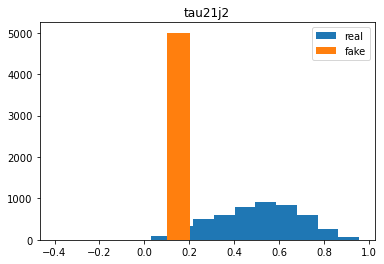

In [75]:
plt.hist(data2,label ='real')
plt.hist(np_arr,label='fake')
plt.title('tau21j2')
plt.legend()